<a href="https://colab.research.google.com/github/ayulockin/LossLandscape/blob/master/ResNet20v1_CIFAR10_Different_Inits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set up and imports

In [1]:
# TensorFlow Imports
import tensorflow as tf
print(tf.__version__)

2.2.0


In [2]:
# Which GPU?
!nvidia-smi

Wed Jul 15 13:28:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
%%capture
!pip install wandb

In [4]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import time

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

## Get the model from [keras-idiomatic-programmer](https://github.com/GoogleCloudPlatform/keras-idiomatic-programmer)

In [6]:
!wget https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py

--2020-07-15 13:28:32--  https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6064 (5.9K) [text/plain]
Saving to: ‘resnet_cifar10.py’

resnet_cifar10.py   100%[===================>]   5.92K  --.-KB/s    in 0s      

2020-07-15 13:28:32 (89.5 MB/s) - ‘resnet_cifar10.py’ saved [6064/6064]



In [7]:
import resnet_cifar10

## Utils

In [8]:
def get_training_model():
    # ResNet20
    n = 2
    depth =  n * 9 + 2
    n_blocks = ((depth - 2) // 9) - 1

    # The input tensor
    inputs = Input(shape=(32, 32, 3))

    # The Stem Convolution Group
    x = resnet_cifar10.stem(inputs)

    # The learner
    x = resnet_cifar10.learner(x, n_blocks)

    # The Classifier for 10 classes
    outputs = resnet_cifar10.classifier(x, 10)

    # Instantiate the Model
    model = Model(inputs, outputs)
    
    return model

## Construct data loaders

In [9]:
# Load the training set of CIFAR10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [11]:
BATCH_SIZE = 128

def normalize(image, label):
    return tf.image.convert_image_dtype(image, tf.float32), label

# Adding data augmentation
def augment(image,label):
    image = tf.image.resize_with_crop_or_pad(image, 40, 40) # Add 8 pixels of padding
    image = tf.image.random_crop(image, size=[32, 32, 3]) # Random crop back to 32x32
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
    image = tf.clip_by_value(image, 0., 1.)
    
    return image, label

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_ds = (
    train_ds
    .shuffle(1024)
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_ds = (
    test_ds
    .map(normalize, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.experimental.AUTOTUNE)
)

## Model sanity checks

In [ ]:
model = get_training_model()
model.summary()

## Callbacks

In [12]:
# Custom LR schedule as mentioned in the LossLandscape paper
LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 1.6*1e-3),
    (9, (1.6*1e-3)/2),
    (19, (1.6*1e-3)/4),
    (29, (1.6*1e-3)/8),
]

def lr_schedule(epoch):
    if (epoch >= 0) & (epoch < 9):
        return LR_SCHEDULE[0][1]
    elif (epoch >= 9) & (epoch < 19):
        return LR_SCHEDULE[1][1]
    elif (epoch >= 19) & (epoch < 29):
        return LR_SCHEDULE[2][1]
    else:
        return LR_SCHEDULE[3][1]

lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr_schedule(epoch), verbose=True)

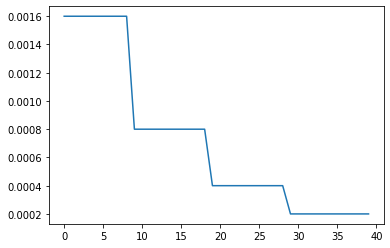

In [13]:
rng = rng = [i for i in range(40)]
plt.plot([lr_schedule(x) for x in rng])
plt.show()

A custom callback to log confusion matrix batchwise (referred from this [tutorial](https://www.tensorflow.org/tensorboard/image_summaries)). 

In [14]:
from sklearn.metrics import confusion_matrix
import itertools
import io

In [15]:
CLASS_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [16]:
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return figure

def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=3)
    # Convert back to NumPy
    image = image.numpy()
    return image

def log_confusion_matrix(epoch, logs):
    # Use the model to predict the values from the validation dataset
    test_pred_raw = model.predict(x_test)
    test_pred = np.argmax(test_pred_raw, axis=1)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test, test_pred)
    # Log the confusion matrix as an image to wandb
    figure = plot_confusion_matrix(cm, class_names=CLASS_NAMES)
    cm_image = plot_to_image(figure)
    wandb.log({'confusion_matrix': wandb.Image(cm_image)})

cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix, verbose=True)

## Model training

In [ ]:
for i in range(10):
    id = 'resnet20v1-aug-diff-inits-corrected' + str(i)
    wandb.init(project='loss-landscape', id=id)
    
    # Train model
    model = get_training_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    start = time.time()
    model.fit(train_ds,
            validation_data=test_ds,
            epochs=40,
            callbacks=[lr_callback, WandbCallback(), cm_callback])
    end = time.time()
    print("Network takes {:.3f} seconds to train".format(end - start))
    
    wandb.log({'training_time': end - start})
    wandb.log({'nb_model_params': model.count_params()})
    model_name = 'resnet20v1-aug-diff-inits-' + str(i) + '.h5'
    model.save(model_name)

Outputs have been Omitted for brevity. 

## Put the model weights in a GCS bucket

In [19]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [20]:
!gsutil -m cp -r resnet20v1-aug-diff-inits-*.h5 gs://losslandscape/ResNet20v1_CIFAR10_Aug_Diff_Inits/

Copying file://resnet20v1-aug-diff-inits-0.h5 [Content-Type=application/octet-stream]...
Copying file://resnet20v1-aug-diff-inits-7.h5 [Content-Type=application/octet-stream]...
Copying file://resnet20v1-aug-diff-inits-1.h5 [Content-Type=application/octet-stream]...
Copying file://resnet20v1-aug-diff-inits-6.h5 [Content-Type=application/octet-stream]...
Copying file://resnet20v1-aug-diff-inits-5.h5 [Content-Type=application/octet-stream]...
Copying file://resnet20v1-aug-diff-inits-4.h5 [Content-Type=application/octet-stream]...
Copying file://resnet20v1-aug-diff-inits-9.h5 [Content-Type=application/octet-stream]...
Copying file://resnet20v1-aug-diff-inits-8.h5 [Content-Type=application/octet-stream]...
Copying file://resnet20v1-aug-diff-inits-2.h5 [Content-Type=application/octet-stream]...
Copying file://resnet20v1-aug-diff-inits-3.h5 [Content-Type=application/octet-stream]...
-
Operation completed over 10 objects/69.4 MiB.                                    
